In [2]:
import numpy as np
import matplotlib.pyplot as plt
from imagenet_stubs.imagenet_2012_labels import IMAGENET_2012_LABELS

from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_keras import KerasModelWrapper

from foolbox.utils import imagenet_example
from foolbox.attacks import SinglePixelAttack, LBFGSAttack
from foolbox.criteria import TargetClassProbability, TopKMisclassification
from foolbox.models import KerasModel
from foolbox import distances

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras import backend as K

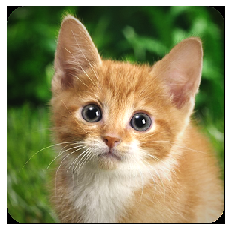

In [2]:
img, label = imagenet_example()
fig = plt.imshow(img.astype(int))
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('images/og.png', bbox_inches='tight', pad_inches=0)
img = np.expand_dims(img, axis=0)

In [3]:
kmodel = ResNet50()
model = KerasModelWrapper(kmodel)
K.set_learning_phase(0)
sess = K.get_session()

In [4]:
img1 = img[:, :, :, ::-1].copy()

In [5]:
decode_predictions(kmodel.predict(img1))

[[('n02123159', 'tiger_cat', 0.29198417),
  ('n02127052', 'lynx', 0.2608814),
  ('n02123045', 'tabby', 0.16957559),
  ('n02124075', 'Egyptian_cat', 0.09674287),
  ('n02123394', 'Persian_cat', 0.045101654)]]

## Fast Gradient Sign Method (FSGM)

In [6]:
img1_min = img1.min()
img1_max = img1.max()

fgsm = FastGradientMethod(model, sess=sess)
# adv_target[0, 340] = 1
fgsm_params = {'eps': 10,
               'clip_min': img1_min,
               'clip_max': img1_max}

In [7]:
adv1 = fgsm.generate_np(img1, **fgsm_params)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [8]:
decode_predictions(kmodel.predict(adv1))

[[('n02441942', 'weasel', 0.36426806),
  ('n02342885', 'hamster', 0.13575558),
  ('n02443114', 'polecat', 0.064164944),
  ('n02112018', 'Pomeranian', 0.05958269),
  ('n02123394', 'Persian_cat', 0.054399088)]]

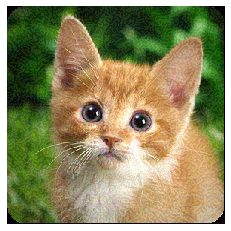

In [9]:
adv1 = adv1[:, :, :, ::-1].copy()
adv1 = adv1.astype(int)
fig = plt.imshow(adv1.reshape(224, 224, 3))
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('images/fgsm.png', bbox_inches='tight', pad_inches=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


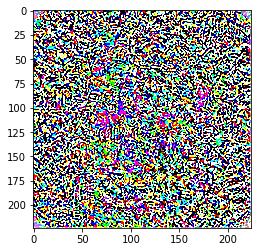

In [10]:
diff1 = adv1 - img
plt.imshow((diff1.reshape(224, 224, 3) + 1) / 2)

In [11]:
tmp = (diff1 + 1) / 2
decode_predictions(kmodel.predict(tmp))
#decode_predictions(kmodel.predict(diff1[:, :, :, ::-1]))
#decode_predictions(kmodel.predict(diff1))

[[('n01608432', 'kite', 0.06881155),
  ('n01828970', 'bee_eater', 0.049870104),
  ('n04266014', 'space_shuttle', 0.041825786),
  ('n04548280', 'wall_clock', 0.033610623),
  ('n02028035', 'redshank', 0.031320304)]]

## LBFGS

In [12]:
model2 = KerasModel(kmodel, bounds=(0, 255))

In [13]:
# Bagel
criterion = TargetClassProbability(931, 0.99)
lbfgs = LBFGSAttack(model2, criterion)
adv2 = lbfgs(img1.reshape(224, 224, 3), label)

In [14]:
decode_predictions(kmodel.predict(adv2.reshape(1, 224, 224, 3)))

[[('n07693725', 'bagel', 0.9910904),
  ('n07742313', 'Granny_Smith', 0.0013662296),
  ('n02123159', 'tiger_cat', 0.00082887744),
  ('n07860988', 'dough', 0.00078945386),
  ('n02342885', 'hamster', 0.00044677668)]]

In [15]:
adv2 = adv2[:, :, ::-1] / 255

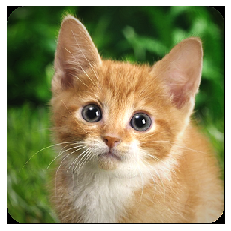

In [16]:
fig = plt.imshow(adv2)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('images/lbfgs.png', bbox_inches='tight', pad_inches=0)

## One Pixel Attack

In [17]:
#criterion2 = TopKMisclassification(3)
pixel_attack = SinglePixelAttack(model2)
adv3 = pixel_attack(img1.reshape(224, 224, 3), label, max_pixels=224**2)

In [18]:
decode_predictions(kmodel.predict(adv3.reshape(1, 224, 224, 3)))

[[('n02127052', 'lynx', 0.2891418),
  ('n02123159', 'tiger_cat', 0.26076633),
  ('n02123045', 'tabby', 0.15287441),
  ('n02124075', 'Egyptian_cat', 0.10407477),
  ('n02123394', 'Persian_cat', 0.044035636)]]

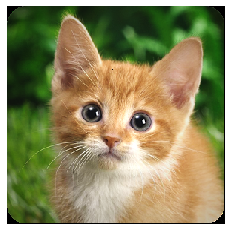

In [19]:
fig = plt.imshow(adv3[:,:,::-1] / 255)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('images/single_pixel.png', bbox_inches='tight', pad_inches=0)